In [1]:
# Copyright 2018 Anar Amirli
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Feature Analysis

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import scipy as sc
import pandas as pd
import operator
import json

# our common utility functions that are used in different notebooks.
from utils import *

pd.options.display.max_columns = None

pd.set_option('compute.use_bottleneck', True)
pd.set_option('compute.use_numexpr', True)

In [8]:
match_id = 60565

with open('../data/general/matches_2017_2018_v1.json') as matches_json:
    matches = json.load(matches_json)

roleassign_df = pd.read_csv('../data/match_{}/role_assignment_count_v2.csv'.format(match_id))
features_df = pd.read_csv('../data/match_{}/features_set.csv'.format(match_id))

## Introduction
In this document, we'll analyze various features obtained from players' $(x,y)$ coordinates and speed $|\vec{V}|$ via visualizations to see which features may be useful for predicting ball locating during the game. 

Some example data with the features we will analyze are as follows:

In [97]:
pd.options.display.float_format = '{:.5f}'.format 
features_df.head(5)

,# refX,refY,refSpeed,refDirectX,refDirectY,homeMaxX,homeMinX,homeMaxY,homeMinY,homeAvgX,homeAvgY,homeAvgSpeed,homeGoalKeeperX,homeGoalKeeperY,homeGoalKeeperSpeed,homeLeftBackMaxX,homeLeftBackMinX,homeLeftBackMaxY,homeLeftBackMinY,homeLeftBackAvgX,homeLeftBackAvgY,homeLeftBackAvgSpeed,homeLeftBackSlowAvgX,homeLeftBackSlowAvgY,homeLeftBackHirAvgX,homeLeftBackHirAvgY,homeLeftBackMaxSprintX,homeLeftBackMaxSprintY,homeLeftBackMaxSprintSpeed,homeCenterBackMaxX,homeCenterBackMinX,homeCenterBackMaxY,homeCenterBackMinY,homeCenterBackAvgX,homeCenterBackAvgY,homeCenterBackAvgSpeed,homeCenterBackSlowAvgX,homeCenterBackSlowAvgY,homeCenterBackHirAvgX,homeCenterBackHirAvgY,homeCenterBackMaxSprintX,homeCenterBackMaxSprintY,homeCenterBackMaxSprintSpeed,homeRightBackMaxX,homeRightBackMinX,homeRightBackMaxY,homeRightBackMinY,homeRightBackAvgX,homeRightBackAvgY,homeRightBackAvgSpeed,homeRightBackSlowAvgX,homeRightBackSlowAvgY,homeRightBackHirAvgX,homeRightBackHirAvgY,homeRightBackMaxSprintX,homeRightBackMaxSprintY,homeRightBackMaxSprintSpeed,homeLeftWingerMaxX,homeLeftWingerMinX,homeLeftWingerMaxY,homeLeftWingerMinY,homeLeftWingerAvgX,homeLeftWingerAvgY,homeLeftWingerAvgSpeed,homeLeftWingerSlowAvgX,homeLeftWingerSlowAvgY,homeLeftWingerHirAvgX,homeLeftWingerHirAvgY,homeLeftWingerMaxSprintX,homeLeftWingerMaxSprintY,homeLeftWingerMaxSprintSpeed,homeCenterMiddleMaxX,homeCenterMiddleMinX,homeCenterMiddleMaxY,homeCenterMiddleMinY,homeCenterMiddleAvgX,homeCenterMiddleAvgY,homeCenterMiddleAvgSpeed,homeCenterMiddleSlowAvgX,homeCenterMiddleSlowAvgY,homeCenterMiddleHirAvgX,homeCenterMiddleHirAvgY,homeCenterMiddleMaxSprintX,homeCenterMiddleMaxSprintY,homeCenterMiddleMaxSprintSpeed,homeRightWingerMaxX,homeRightWingerMinX,homeRightWingerMaxY,homeRightWingerMinY,homeRightWingerAvgX,homeRightWingerAvgY,homeRightWingerAvgSpeed,homeRightWingerSlowAvgX,homeRightWingerSlowAvgY,homeRightWingerHirAvgX,homeRightWingerHirAvgY,homeRightWingerMaxSprintX,homeRightWingerMaxSprintY,homeRightWingerMaxSprintSpeed,homeCenterForwardMaxX,homeCenterForwardMinX,homeCenterForwardMaxY,homeCenterForwardMinY,homeCenterForwardAvgX,homeCenterForwardAvgY,homeCenterForwardAvgSpeed,homeCenterForwardSlowAvgX,homeCenterForwardSlowAvgY,homeCenterForwardHirAvgX,homeCenterForwardHirAvgY,homeCenterForwardMaxSprintX,homeCenterForwardMaxSprintY,homeCenterForwardMaxSprintSpeed,awayMaxX,awayMinX,awayMaxY,awayMinY,awayAvgX,awayAvgY,awayAvgSpeed,awayGoalKeeperX,awayGoalKeeperY,awayGoalKeeperSpeed,awayLeftBackMaxX,awayLeftBackMinX,awayLeftBackMaxY,awayLeftBackMinY,awayLeftBackAvgX,awayLeftBackAvgY,awayLeftBackAvgSpeed,awayLeftBackSlowAvgX,awayLeftBackSlowAvgY,awayLeftBackHirAvgX,awayLeftBackHirAvgY,awayLeftBackMaxSprintX,awayLeftBackMaxSprintY,awayLeftBackMaxSprintSpeed,awayCenterBackMaxX,awayCenterBackMinX,awayCenterBackMaxY,awayCenterBackMinY,awayCenterBackAvgX,awayCenterBackAvgY,awayCenterBackAvgSpeed,awayCenterBackSlowAvgX,awayCenterBackSlowAvgY,awayCenterBackHirAvgX,awayCenterBackHirAvgY,awayCenterBackMaxSprintX,awayCenterBackMaxSprintY,awayCenterBackMaxSprintSpeed,awayRightBackMaxX,awayRightBackMinX,awayRightBackMaxY,awayRightBackMinY,awayRightBackAvgX,awayRightBackAvgY,awayRightBackAvgSpeed,awayRightBackSlowAvgX,awayRightBackSlowAvgY,awayRightBackHirAvgX,awayRightBackHirAvgY,awayRightBackMaxSprintX,awayRightBackMaxSprintY,awayRightBackMaxSprintSpeed,awayLeftWingerMaxX,awayLeftWingerMinX,awayLeftWingerMaxY,awayLeftWingerMinY,awayLeftWingerAvgX,awayLeftWingerAvgY,awayLeftWingerAvgSpeed,awayLeftWingerSlowAvgX,awayLeftWingerSlowAvgY,awayLeftWingerHirAvgX,awayLeftWingerHirAvgY,awayLeftWingerMaxSprintX,awayLeftWingerMaxSprintY,awayLeftWingerMaxSprintSpeed,awayCenterMiddleMaxX,awayCenterMiddleMinX,awayCenterMiddleMaxY,awayCenterMiddleMinY,awayCenterMiddleAvgX,awayCenterMiddleAvgY,awayCenterMiddleAvgSpeed,awayCenterMiddleSlowAvgX,awayCenterMiddleSlowAvgY,awayCenterMiddleHirAvgX,awayCenterMiddleHirAvgY,awayCenterMiddleMaxSprintX,awayCenterMiddleMaxSprintY,awayCenterMiddleMaxSprintSpeed,awayRightWingerMax

## Role assignment analysis

Role assignment is important standpoint in our project. Our approach is role based, rather than using each player's various data, we group them to different roles based on their average positions for past timeline of 15 minutes, then use these group features; such as average coordinate and seed of group, fastest player coordinate and seed in the group, for predicting player location. [Here is](scale_roleassign_visualization.ipynb) is more detailed information on how to do arole assignment.

We have folowing roles:

In [30]:
role_dict = {
    0: 'LeftBack',
    1: 'CenterBack',
    2: 'RightBack',
    3: 'LeftWinger',
    4: 'CenterMiddle',
    5: 'RightWinger',
    6: 'CenterForward'
}

Some example data with the role assigment frame we will analyze are as follows:

In [19]:
pd.options.display.float_format = '{:.0f}'.format 
roleassign_df.head(5)

,# matchId,half,min,sec,homeLeftBack,homeCenterBack,homeRightBack,homeLeftWinger,homeCenterMiddle,homeRightWinger,homeCenterForward,awayLeftBack,awayCenterBack,awayRightBack,awayLeftWinger,awayCenterMiddle,awayRightWinger,awayCenterForward
0,60565,1,2,0,1,2,1,1,2,1,2,0,1,1,2,2,2,2
1,60565,1,2,1,1,2,1,1,2,1,2,0,2,0,2,2,2,2
2,60565,1,2,2,1,2,1,1,2,1,2,0,2,0,2,2,2,2
3,60565,1,2,3,1,2,1,1,2,1,2,0,2,0,2,2,2,2
4,60565,1,2,4,1,2,1,1,2,1,2,0,2,0,2,2,2,2


### Previous role dictionary

In [7]:
role_dict2 = {
    0: 'LeftBack',
    1: 'CenterBack',
    2: 'RightBack',
    3: 'LeftMiddle',
    4: 'CenterMiddle',
    5: 'RightMiddle',
    6: 'AtackingMiddle',
    7: 'LeftForward',
    8: 'CenterForward',
    9: 'RightForward'
}

In [8]:
def plot_players_assignments(role_dict, *args, source, **kwargs):
    '''
    Plot bar-chart for role assignment of a pandas DataFrame or Series.
    
    Parameters
    ----------
    role_dict: players role dictionary 
          
    *args: Forwarded to matplotlib.pyplot.plot
    
    source: raw data soruce
    
    **kwargs: Forwarded to matplotlib.pyplot.plot
    '''
    role_rng = len(role_dict)
    role_assignment_count = np.zeros(shape=(role_rng), dtype=np.float)
    match_count = 0

    # reading through the all matches
    for match_data in matches:
        match_id = int(match_data['id'])
        try:
            roleassign_df = pd.read_csv(source.format(match_id))
            for i in range(role_rng):
                role_assignment_count[i] += (roleassign_df['home'+ role_dict[i]].sum(axis=0)+ roleassign_df['away'+ role_dict[i]].sum(axis=0))
            match_count+=1
        except FileNotFoundError:
            pass

    for i in range(role_rng):
        role_assignment_count[i] = role_assignment_count[i]/(match_count*2*5000)

    label=[]
    for i in range(role_rng):
        label.append(role_dict[i])

    y_pos = np.arange(len(label))
    plt.bar(y_pos, role_assignment_count, align='center', alpha=0.5)
    plt.xticks(y_pos, label, rotation='vertical')
    plt.ylabel('Number of assignments')
    plt.xlabel('Postion name')
    plt.title('Average number of player assignations to a role')
    plt.show()

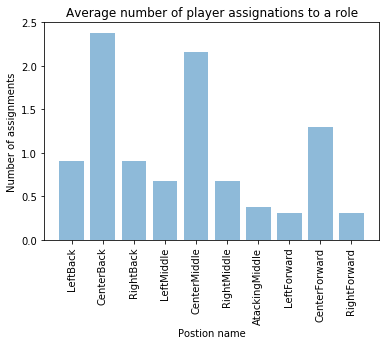

In [9]:
plot_players_assignments(role_dict=role_dict2, source='../data/match_{}/role_assignment_count.csv')

In the above diagram, we can see that Center Back, Center Middle, and Center Forward are the most dominant positions to which players were assigned most. This can be explained with that football matches are generally more concentrated to the center of the pitch. Although Center Forward is among the most assigned position but is only makes about half of the Center Back and Center Middle. We can also categorize Left Back and Right Back as common roles as they are just slightly below Center Forwad, between 2 and 1 assignation to each.<br>
<br>The number of other positions (Left Forward, Right Forward, Atacking Middle) assignation is low compared to 3 major role. That means, their groups features set completely equal to zero most of the time, so that can cause some noise while building a predictive model.

### What can we do about this problem?

#### 1. Combine alike roles together

We can combine less occurred roles together with the most assigned roles of the same category and can me some adjusment on segments borders.
For example, Left Forward and Right Forward are least assigned categories, we can some them with Left/Right Wingers as Winger groups.<br>
New Combination:
* *Left Back* (0,40,0,19)
* *Center Back* (0,35,19,49)
* *Right Back* (0,40,49,68)
* *Center Middle* (35,75,49,68)
* *Left Middle (+Left Forward)* (40,105,0,19)
* *Center Forward (+Atacking Middle)* (75,105,19,49)
* *Right Middle (+Right Middle)* (40,105,49,68)

From the bar chart shown above, we can easily understand that the number of players assigned to each position during the whole match. Therefore, we can identify specific position which generally occupied by only one player and them reduce the number of extra features calculated for this area.

### Average number of player assignations after modification (with new role dictionary):

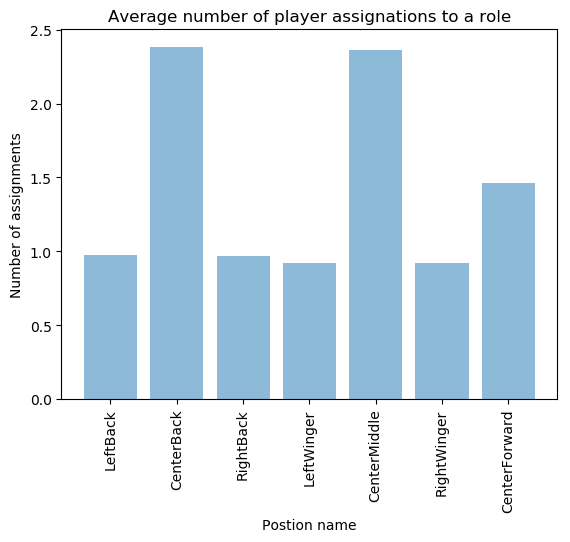

In [37]:
plot_players_assignments(role_dict=role_dict2, source='../data/match_{}/role_assignment_count_v2.csv')

After modification, it seems that on average every position segment has at least 1 player assignation in each distinct frame. Also, the assignation number of side (1) and center (2-3 in general) positions are as we expected.

## Histogram Analysis of Various Features

In this section, we'll plot histograms about some features to generalize the data we have by feature construction.<br>

### Center  Group players

Center group is consist of Center Back, Center Middlefield, and Center Forward player groups.

In [33]:
try:
    features_df = pd.read_csv('../data/match_{}/features_set.csv'.format(match_id))
except FileNotFoundError:
    pass

In [34]:
def plot_hist(cols, *args, title, **kwargs):
    '''
    Plot histogram for role assignment of a pandas DataFrame or Series.
    Data points should be one second apart.
    
    Parameters
    ----------
    cols: pandas DataFrame or Series object containing arrays in its columns
          whose differentials will be plotted.
          
    *args: Forwarded to matplotlib.pyplot.plot
    
    title: plot title
    
    **kwargs: Forwarded to matplotlib.pyplot.plot
    '''
    plt.figure(figsize=(13, 8))
    for col, (raw, header) in cols.items():
        plt.subplot(2, 2, col)
        raw = np.array(raw)
        plt.xlabel('Horizontal (m)')
        plt.ylabel('Vertical (m)')
        plt.hist2d((raw[:,0]), (raw[:,1]), cmap='hot', bins=(32), range=[[0,105],[0,68]]) 
        plt.title(header+title)
        plt.colorbar()
    plt.tight_layout()

In [10]:
def get_location_info(xt_small, xt_big, yt_small, yt_big, x_pos, y_pos, group_v, group_h, group_s, list_v, list_h, list_s, ball_cord):
    for frame in range(len(features_df)):
        p_index = pith_index[frame]
        if x_pos[frame]!=0 and p_index !=0:
            if x_pos[frame]>=xt_small and x_pos[frame]<=xt_big and y_pos[frame]>=yt_small and y_pos[frame]<=yt_big:
                ball_cord.append([x_pos[frame], y_pos[frame]])
                if group_v[0][frame]!=0:
                    list_v.append([group_v[0][frame], group_v[1][frame]])
                if group_h[0][frame]!=0:
                    list_h.append([group_h[0][frame], group_h[1][frame]])
                if group_s[0][frame]!=0:
                    list_s.append([group_s[0][frame], group_s[1][frame]])

In [11]:
# center-back slow group avrg player position
cb_slow_avg_cord = []
cb_hir_avg_cord = []
cb_sprint_avg_cord = []
cb_actual_ball_cord = []

# forward players
f_slow_avg_cord = []
f_hir_avg_cord = []
f_sprint_avg_cord = []
f_actual_ball_cord = []


# center middlefielders players
cm_slow_avg_cord = []
cm_hir_avg_cord = []
cm_sprint_avg_cord = []
cm_actual_ball_cord = []

cb_slow = [features_df['homeCenterBackSlowAvgX'], features_df['homeCenterBackSlowAvgY']]
cb_hir = [features_df['homeCenterBackHirAvgX'], features_df['homeCenterBackHirAvgY']]
cb_sprint = [features_df['homeCenterBackMaxSprintX'], features_df['homeCenterBackMaxSprintY']]

f_slow = [features_df['homeCenterForwardSlowAvgX'], features_df['homeCenterForwardSlowAvgY']]
f_hir = [features_df['homeCenterForwardHirAvgX'], features_df['homeCenterForwardHirAvgY']]
f_sprint = [features_df['homeCenterForwardMaxSprintX'], features_df['homeCenterForwardMaxSprintY']]

cm_slow = [features_df['homeCenterMiddleSlowAvgX'], features_df['homeCenterMiddleSlowAvgY']]
cm_hir = [features_df['homeCenterMiddleHirAvgX'], features_df['homeCenterMiddleHirAvgY']]
cm_sprint = [features_df['homeCenterMiddleMaxSprintX'], features_df['homeCenterMiddleMaxSprintY']]


x_pos = features_df['xpos']
y_pos = features_df['ypos']
pith_index = features_df['pitch_index']


get_location_info(0, 50, 0, 68, x_pos, y_pos, cb_slow, cb_hir, cb_sprint, 
                  cb_slow_avg_cord, cb_hir_avg_cord, cb_sprint_avg_cord, cb_actual_ball_cord)

get_location_info(50, 105, 0, 68, x_pos, y_pos, f_slow, f_hir, f_sprint, 
                  f_slow_avg_cord, f_hir_avg_cord, f_sprint_avg_cord, f_actual_ball_cord)

get_location_info(35, 75, 0, 68, x_pos, y_pos, cm_slow, cm_hir, cm_sprint, 
                  cm_slow_avg_cord, cm_hir_avg_cord, cm_sprint_avg_cord, cm_actual_ball_cord)


cols_cb = {
    1 : (cb_slow_avg_cord, 'Center-back SLOW avg pos'),
    2 : (cb_hir_avg_cord, 'Center-back HIR avg pos'),
    3 : (cb_sprint_avg_cord, 'Center-back max-SPRINT pos'),
    4 : (cb_actual_ball_cord, 'Ball itself')
}

cols_f = {
    1 : (f_slow_avg_cord, 'Center-forward SLOW avg pos'),
    2 : (f_hir_avg_cord, 'Center-forward HIR avg pos'),
    3 : (f_sprint_avg_cord, 'Center-forward max-SPRINT pos'),
    4 : (f_actual_ball_cord, 'Ball itself')
}

cols_cm = {
    1 : (cm_slow_avg_cord, 'Center-middle SLOW avg pos'),
    2 : (cm_hir_avg_cord, 'Center-middle HIR avg pos'),
    3 : (cm_sprint_avg_cord, 'Center-middle max-SPRINT pos'),
    4 : (cm_actual_ball_cord, 'Ball itself')
}

#### *i. Center Defence*
Histogram for SLOW, HIR, Max-SPRINT player groups.

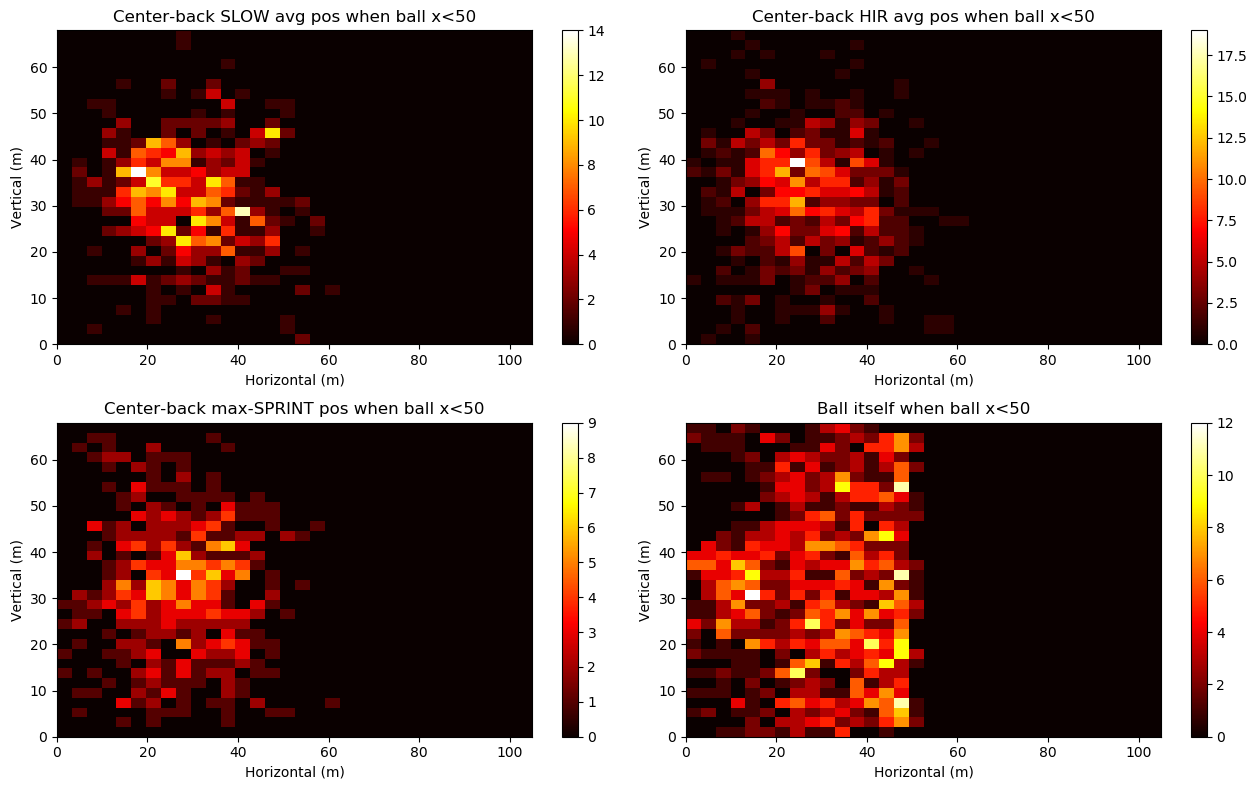

In [37]:
plot_hist(cols=cols_cb, title=' when ball x<50')

#### *ii. Center Middlefielders*
Histogram for SLOW, HIR, Max-SPRINT player groups.

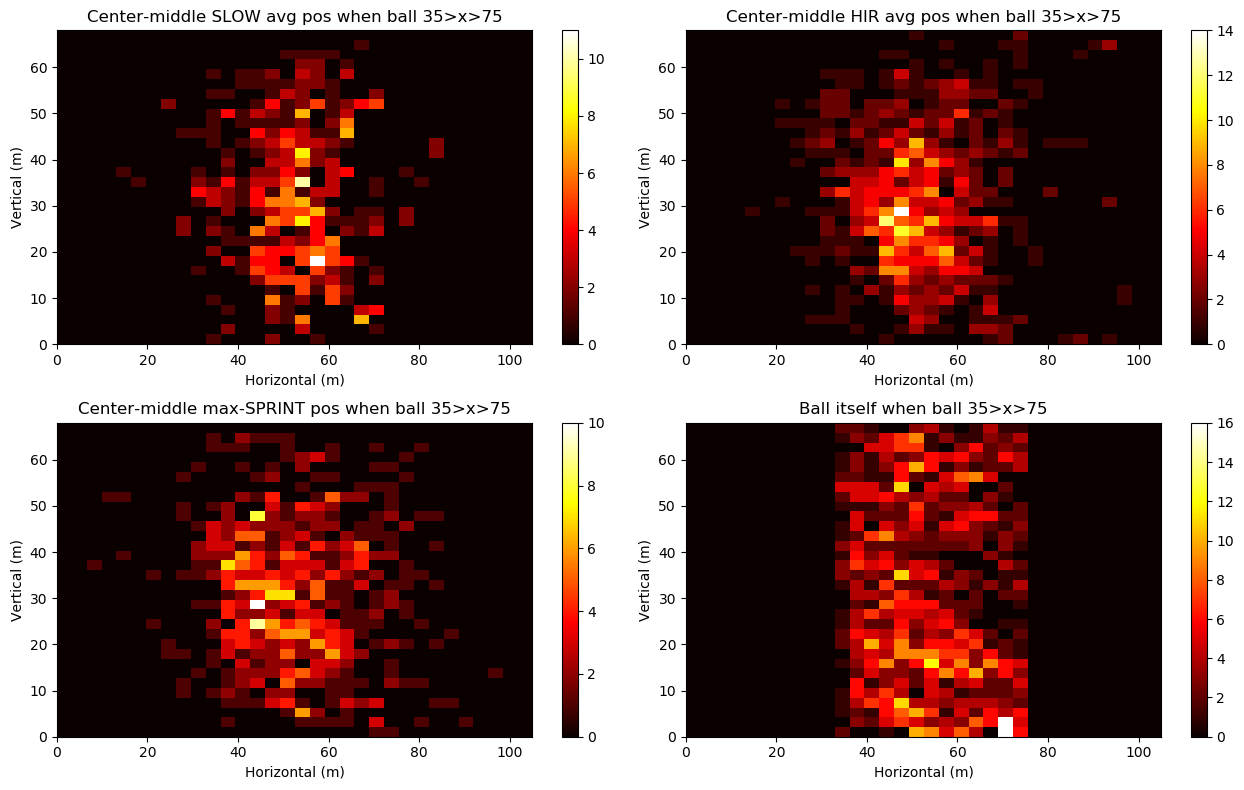

In [38]:
plot_hist(cols=cols_cm, title=' when ball 35>x>75')

#### *iii. Center Forward*
Histogram for SLOW, HIR, Max-SPRINT player groups.

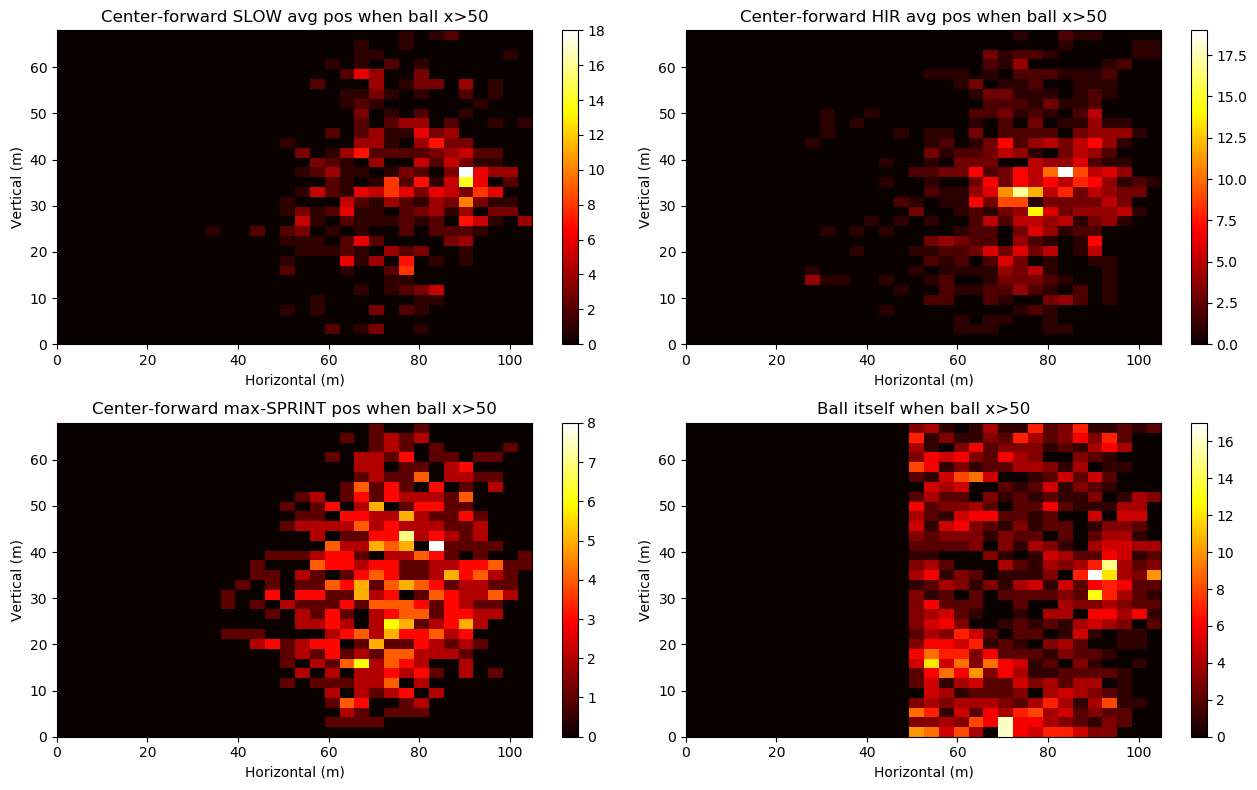

In [39]:
plot_hist(cols=cols_f, title=' when ball x>50')

### Winger  Group player

Winger group is consist of Left Back, Right Back, Left Winger and Right Winger player groups.

In [40]:
# left back    
lb_slow_avg_cord = []
lb_hir_avg_cord = []
lb_sprint_avg_cord = []
lb_actual_ball_cord = []

# right back    
rb_slow_avg_cord = []
rb_hir_avg_cord = []
rb_sprint_avg_cord = []
rb_actual_ball_cord = []

# left winger
lw_slow_avg_cord = []
lw_hir_avg_cord = []
lw_sprint_avg_cord = []
lw_actual_ball_cord = []

# right winger
rw_slow_avg_cord = []
rw_hir_avg_cord = []
rw_sprint_avg_cord = []
rw_actual_ball_cord = []

# left back
lb_slow = [features_df['homeLeftBackSlowAvgX'], features_df['homeLeftBackSlowAvgY']]
lb_hir = [features_df['homeLeftBackHirAvgX'], features_df['homeLeftBackHirAvgY']]
lb_sprint = [features_df['homeLeftBackMaxSprintX'], features_df['homeLeftBackMaxSprintY']]
# right back
rb_slow = [features_df['homeRightBackSlowAvgX'], features_df['homeRightBackSlowAvgY']]
rb_hir = [features_df['homeRightBackHirAvgX'], features_df['homeRightBackHirAvgY']]
rb_sprint = [features_df['homeRightBackMaxSprintX'], features_df['homeRightBackMaxSprintY']]
# left winger
lw_slow = [features_df['homeLeftWingerSlowAvgX'], features_df['homeLeftWingerSlowAvgY']]
lw_hir = [features_df['homeLeftWingerHirAvgX'], features_df['homeLeftWingerHirAvgY']]
lw_sprint = [features_df['homeLeftWingerMaxSprintX'], features_df['homeLeftWingerMaxSprintY']]
# right winger
rw_slow = [features_df['homeRightWingerSlowAvgX'], features_df['homeRightWingerSlowAvgY']]
rw_hir = [features_df['homeRightWingerHirAvgX'], features_df['homeRightWingerHirAvgY']]
rw_sprint = [features_df['homeRightWingerMaxSprintX'], features_df['homeRightWingerMaxSprintY']]
# ball position
x_pos = features_df['xpos']
y_pos = features_df['ypos']
# ball segment index
pith_index = features_df['pitch_index']



# left back
get_location_info(0, 50, 0, 34, x_pos, y_pos, lb_slow, lb_hir, lb_sprint, 
                  lb_slow_avg_cord, lb_hir_avg_cord, lb_sprint_avg_cord, lb_actual_ball_cord)
# right back
get_location_info(0, 50, 34, 68, x_pos, y_pos, rb_slow, rb_hir, rb_sprint, 
                  rb_slow_avg_cord, rb_hir_avg_cord, rb_sprint_avg_cord, rb_actual_ball_cord)
# left winger
get_location_info(45, 105, 0, 34, x_pos, y_pos, lw_slow, lw_hir, lw_sprint, 
                  lw_slow_avg_cord, lw_hir_avg_cord, lw_sprint_avg_cord, lw_actual_ball_cord)
# right winger
get_location_info(45, 105, 34, 68, x_pos, y_pos, rw_slow, rw_hir, rw_sprint, 
                  rw_slow_avg_cord, rw_hir_avg_cord, rw_sprint_avg_cord, rw_actual_ball_cord)


cols_lb = {
    1 : (lb_slow_avg_cord, 'Left-back SLOW avg pos'),
    2 : (lb_hir_avg_cord, 'Left-back HIR avg pos'),
    3 : (lb_sprint_avg_cord, 'Left-back max-SPRINT pos'),
    4 : (lb_actual_ball_cord, 'Ball itself')
}

cols_rb = {
    1 : (rb_slow_avg_cord, 'Right-back SLOW avg pos'),
    2 : (rb_hir_avg_cord, 'Right-back HIR avg pos'),
    3 : (rb_sprint_avg_cord, 'Right-back max-SPRINT pos'),
    4 : (rb_actual_ball_cord, 'Ball itself')
}

cols_lw = {
    1 : (lw_slow_avg_cord, 'Left-winger SLOW avg pos'),
    2 : (lw_hir_avg_cord, 'Left-winger HIR avg pos'),
    3 : (lw_sprint_avg_cord, 'Left-winger max-SPRINT pos'),
    4 : (lw_actual_ball_cord, 'Ball itself')
}

cols_rw = {
    1 : (rw_slow_avg_cord, 'Right-winger SLOW avg pos'),
    2 : (rw_hir_avg_cord, 'Right-winger HIR avg pos'),
    3 : (rw_sprint_avg_cord, 'Right-winger max-SPRINT pos'),
    4 : (rw_actual_ball_cord, 'Ball itself')
}

#### *i. Left Back*
Average pisition of left-back player group

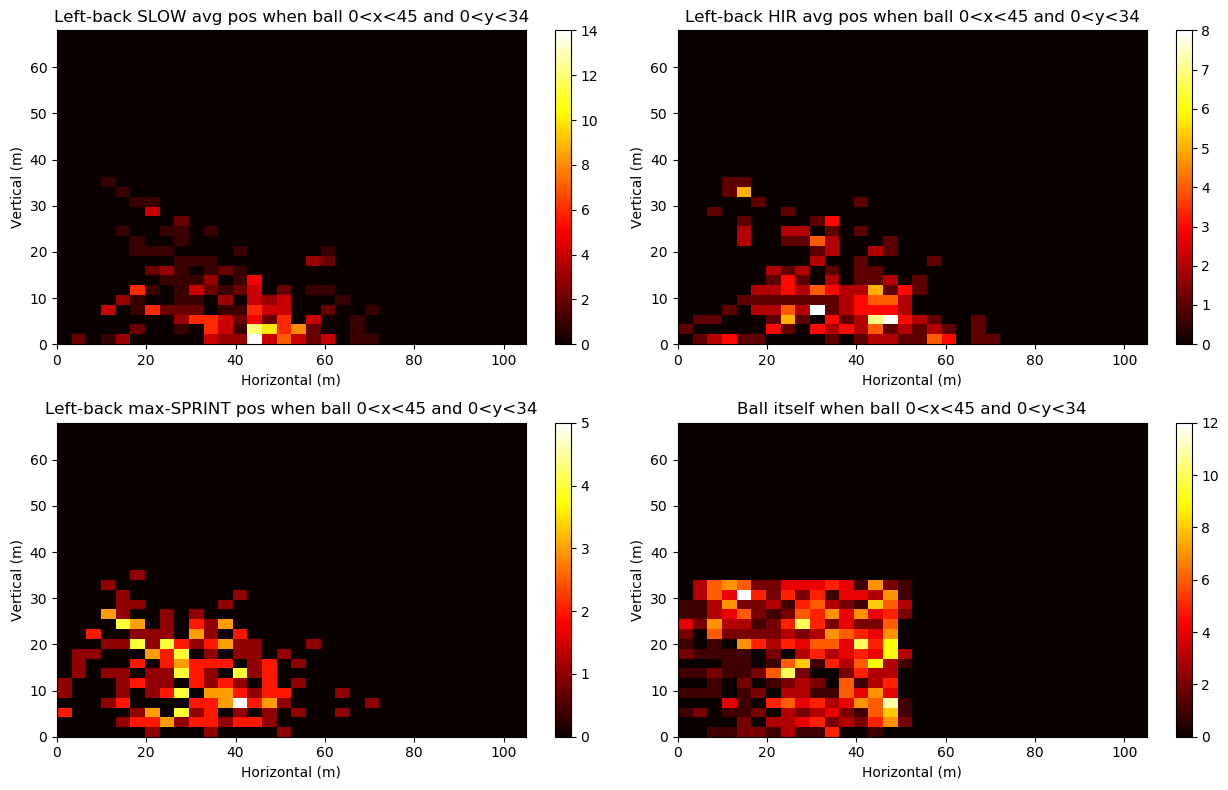

In [41]:
plot_hist(cols=cols_lb, title=' when ball 0<x<45 and 0<y<34')

#### *ii. Right Back*
Average pisition of right-back player group

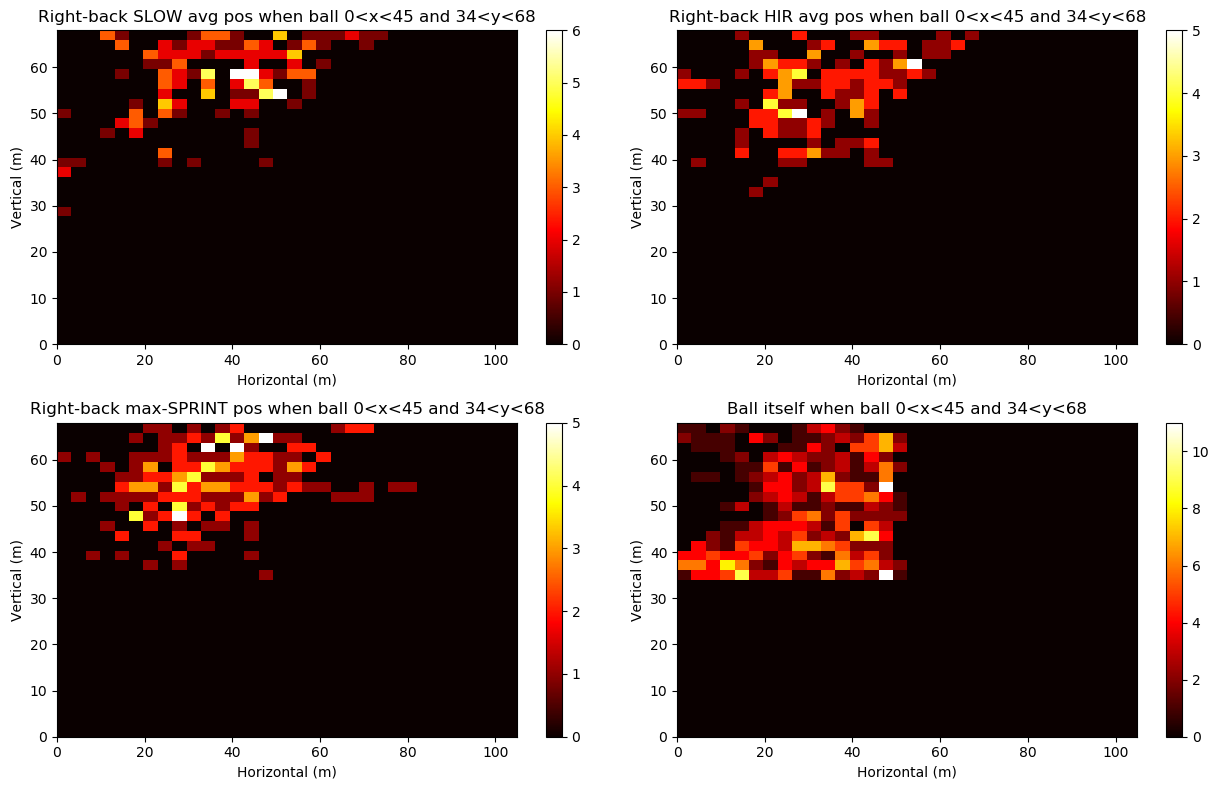

In [42]:
plot_hist(cols=cols_rb, title=' when ball 0<x<45 and 34<y<68')

#### *iii. Left Winger*
Average pisition of left-winger player group

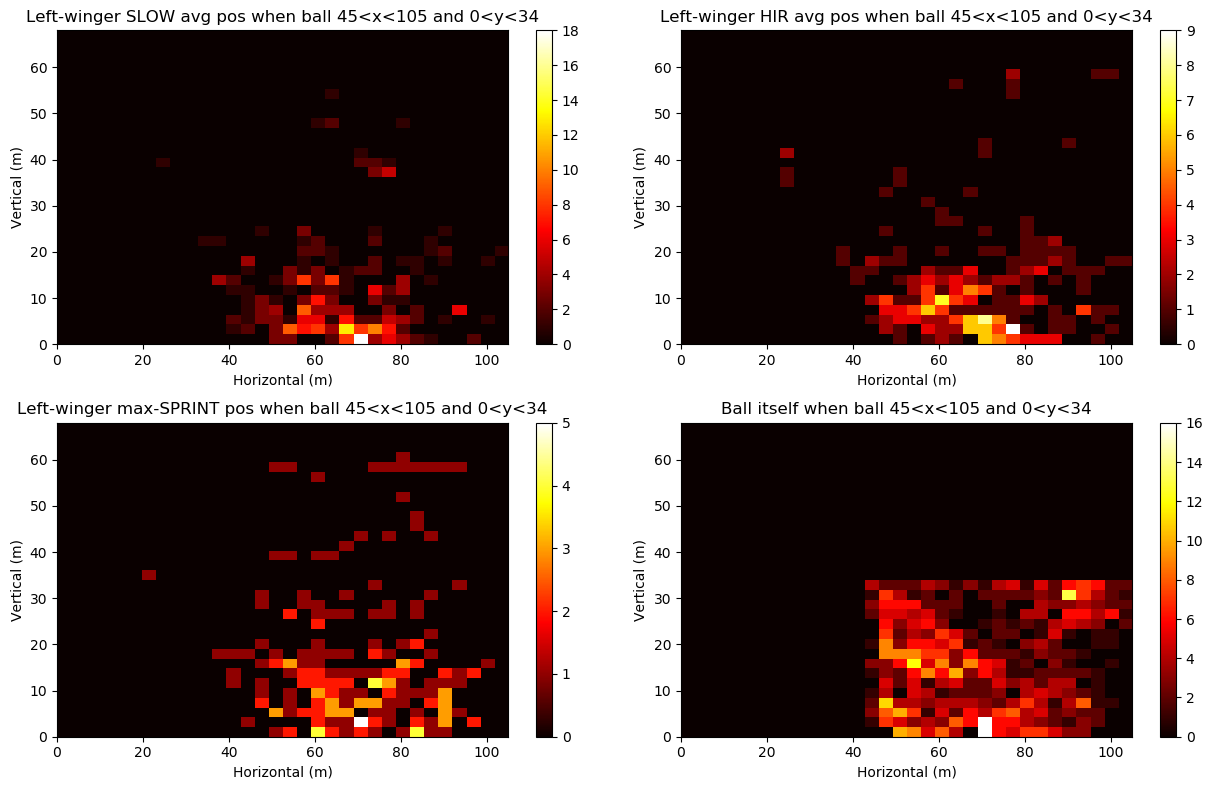

In [43]:
plot_hist(cols=cols_lw, title=' when ball 45<x<105 and 0<y<34')

#### *iv. Right Winger*
Average pisition of right-winger player group

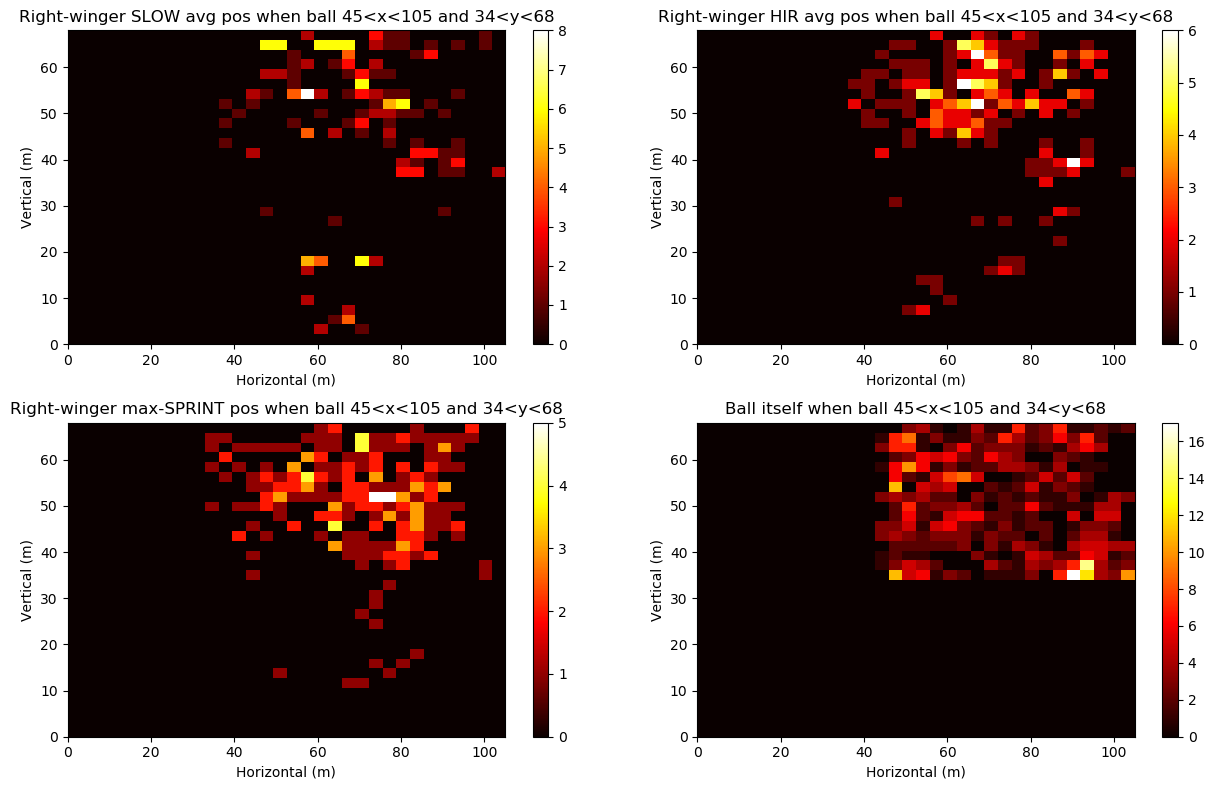

In [44]:
plot_hist(cols=cols_rw, title=' when ball 45<x<105 and 34<y<68')

### Referee Position for Ball Location Detection

Referees is one of the most importan figures in the soccer match, he/she oftentimes stands next to the player beind the ball in order to watch for fouls occurring. So their position, both $x,y$ coordinates, can be used for ball location detection. 

In [45]:
referee_cord = [features_df['# refX'], features_df['refY']]
ball_cord = [features_df['xpos'], features_df['ypos']]
pith_index = features_df['pitch_index']

referee_cord_l = []
ball_cord_l = []
referee_index = []
ball_index = []

for frame in range(len(features_df)):
    p_index = pith_index[frame]
    if ball_cord[0][frame]!=0 and p_index !=0:
        ball_index.append([p_index])
        referee_index.append([define_pitch_index(referee_cord[0][frame], referee_cord[1][frame])])
        referee_cord_l.append([referee_cord[0][frame], referee_cord[1][frame]])
        ball_cord_l.append([ball_cord[0][frame], ball_cord[1][frame]])
        
referee_cord_l = np.array(referee_cord_l)
ball_cord_l = np.array(ball_cord_l)
referee_index = np.array(referee_index)
ball_index = np.array(ball_index)

#### *i. Referee and Ball (x,y) cords*

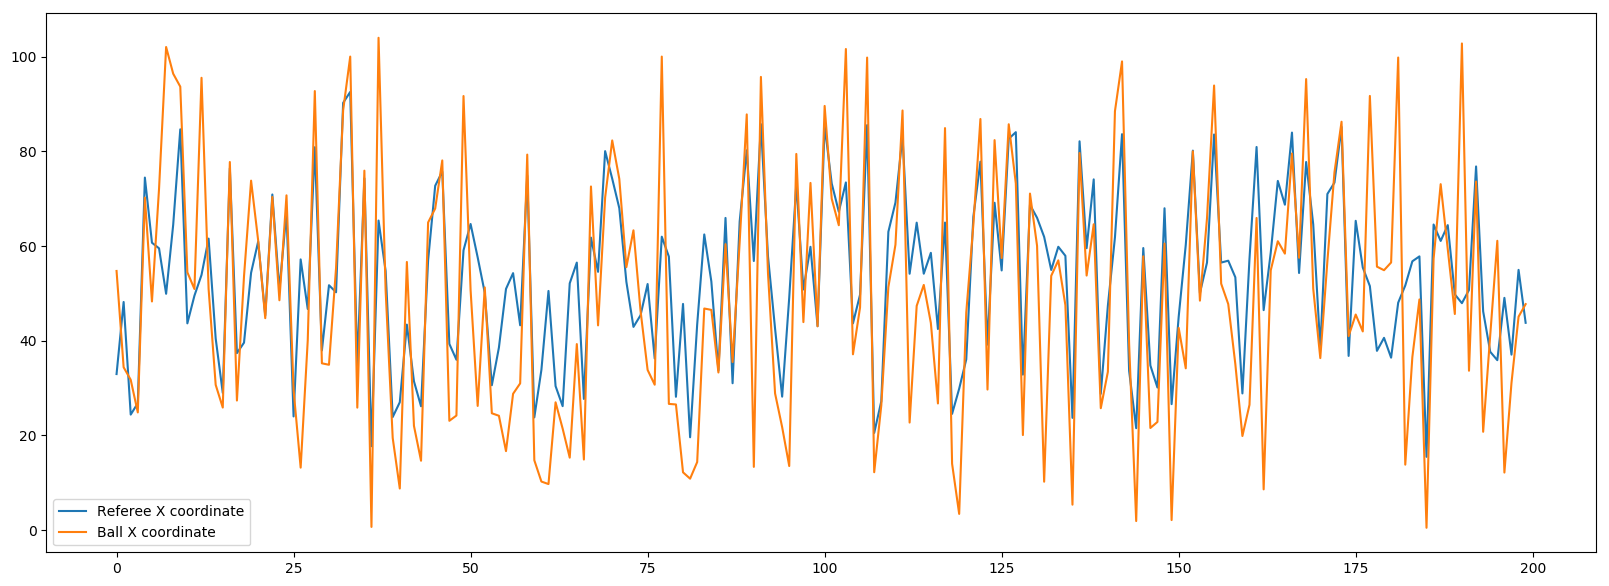

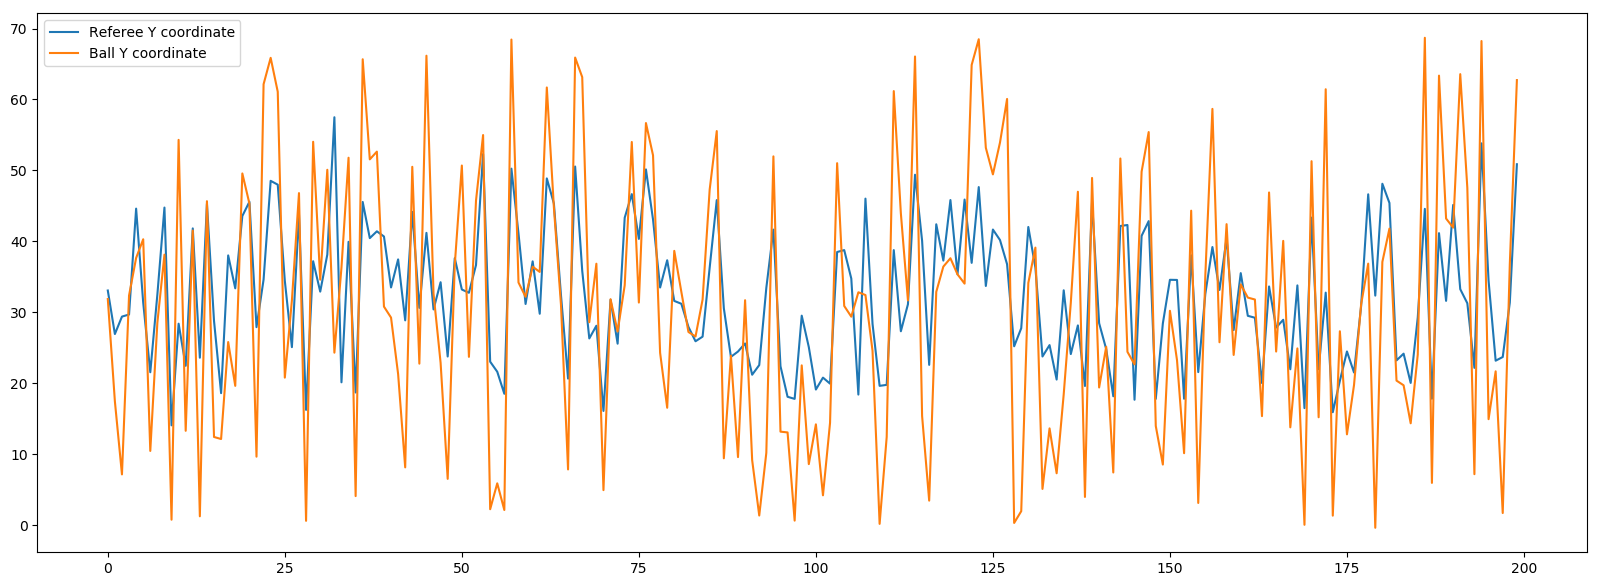

In [50]:
referee_x = np.array(referee_cord_l[:,0])
referee_y = np.array(referee_cord_l[:,1])
ball_x = np.array(ball_cord_l[:,0])
ball_y = np.array(ball_cord_l[:,1])
referee_idx  = np.array(referee_index[:,0])
ball_idx  = np.array(ball_index[:,0])

idx = np.random.choice(np.arange(len(referee_cord_l)), 200, replace=False)
referee_x = referee_x[idx]
referee_y = referee_y[idx]
ball_x = ball_x[idx]
ball_y = ball_y[idx]
referee_idx = referee_idx[idx]
ball_idx = ball_idx[idx]

df = pd.DataFrame({
'Referee X coordinate': referee_x,
'Referee Y coordinate': referee_y,
'Ball X coordinate': ball_x,
'Ball Y coordinate': ball_y
})

plt.figure(figsize=(20,7))
df[['Referee X coordinate', 'Ball X coordinate']].plot(ax = plt.gca())
plt.show()
plt.figure(figsize=(20,7))
df[['Referee Y coordinate', 'Ball Y coordinate']].plot(ax = plt.gca())
plt.show()

#### *ii. Referee and Ball location segments (index)*

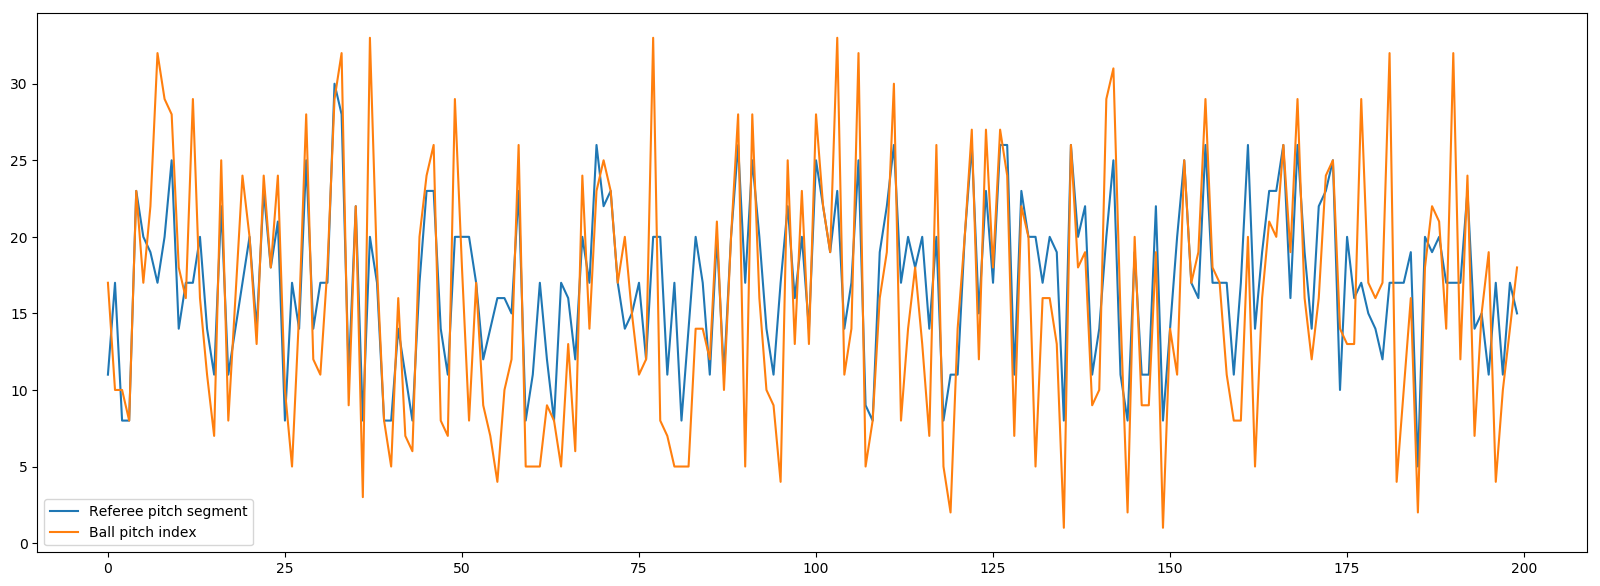

In [51]:
df2 = pd.DataFrame({
'Referee pitch segment': referee_idx,
'Ball pitch index': ball_idx
})

plt.figure(figsize=(20,7))
df2[['Referee pitch segment', 'Ball pitch index']].plot(ax = plt.gca())
plt.show()

### Center Group Speed Anaylsis

In [52]:
def initialize_data(x1,x2,y1,y2, group_data, ball_cord, pith_index):
    # x1,x2,y1,y2 for ball location
    group_cord_l = []
    ball_index = []
    for frame in range(len(features_df)):
        p_index = pitch_index[frame]
        if ball_cord[0][frame]!=0 and ball_cord[0][frame]>=x1 and ball_cord[0][frame]<=x2 and ball_cord[1][frame]>=y1 and ball_cord[1][frame]<=y2 and p_index !=0 and group_data[0][frame]!=0:
            group_cord_l.append([define_pitch_index(group_data[0][frame], group_data[1][frame])])
            ball_index.append([p_index])

    
    group_cord_l = np.array(group_cord_l)
    ball_index = np.array(ball_index)

    return group_cord_l, ball_index

In [53]:
cf_max_cord = [features_df['homeCenterMiddleMaxSprintX'], features_df['homeCenterMiddleMaxSprintY']]
cf_hir_cord = [features_df['homeCenterMiddleHirAvgX'], features_df['homeCenterMiddleHirAvgY']]
cf_slow_cord = [features_df['homeCenterMiddleSlowAvgX'], features_df['homeCenterMiddleSlowAvgY']]


cb_slow_cord = [features_df['homeCenterMiddleSlowAvgX'], features_df['homeCenterMiddleSlowAvgY']]
cb_hir_cord = [features_df['homeCenterBackHirAvgX'], features_df['homeCenterBackHirAvgY']]

ball_cord = [features_df['xpos'], features_df['ypos']]
pitch_index = features_df['pitch_index']

cm_max_cord_l, cm_max_ball_cord_l =  initialize_data(40,80,14,54, cf_max_cord, ball_cord, pitch_index)
cm_hir_cord_l, cm_hir_ball_cord_l =  initialize_data(40,80,14,54, cf_hir_cord, ball_cord, pitch_index)
cm_slow_cord_l,cm_slow_ball_cord_l =  initialize_data(40,80,14,54, cf_slow_cord, ball_cord, pitch_index)


cb_slow_cord_l,cb_slow_ball_cord_l =  initialize_data(0,50,0,68,cb_slow_cord, ball_cord, pitch_index)
cb_hir_cord_l,cb_hir_ball_cord_l =  initialize_data(0,50,0,68, cb_hir_cord, ball_cord, pitch_index)


cb_df = pd.DataFrame({
'Center-Back pitch segment': cb_slow_cord_l[:,0],
'Ball pitch segment': cb_slow_ball_cord_l[:,0],  
})

cb_df2 = pd.DataFrame({
'Center-Back pitch segment': cb_hir_cord_l[:,0],
'Ball pitch segment': cb_hir_ball_cord_l[:,0],  
})


df = pd.DataFrame({
'Center-Middle ptich segment': cm_slow_cord_l[:,0],
'Ball pitch segment': cm_slow_ball_cord_l[:,0],  
})

df1 = pd.DataFrame({
'Center-Middle ptich segment': cm_hir_cord_l[:,0],
'Ball pitch segment': cm_hir_ball_cord_l[:,0],  
})


df2 = pd.DataFrame({
'Center-Middle ptich segment': cm_max_cord_l[:,0],
'Ball pitch segment': cm_max_ball_cord_l[:,0],  
})

### Center Back

#### *i. Center Back SLOW group $(\vec{V}\leq1.5)$ when ball actual position is $x_{ball}\leq50$* 

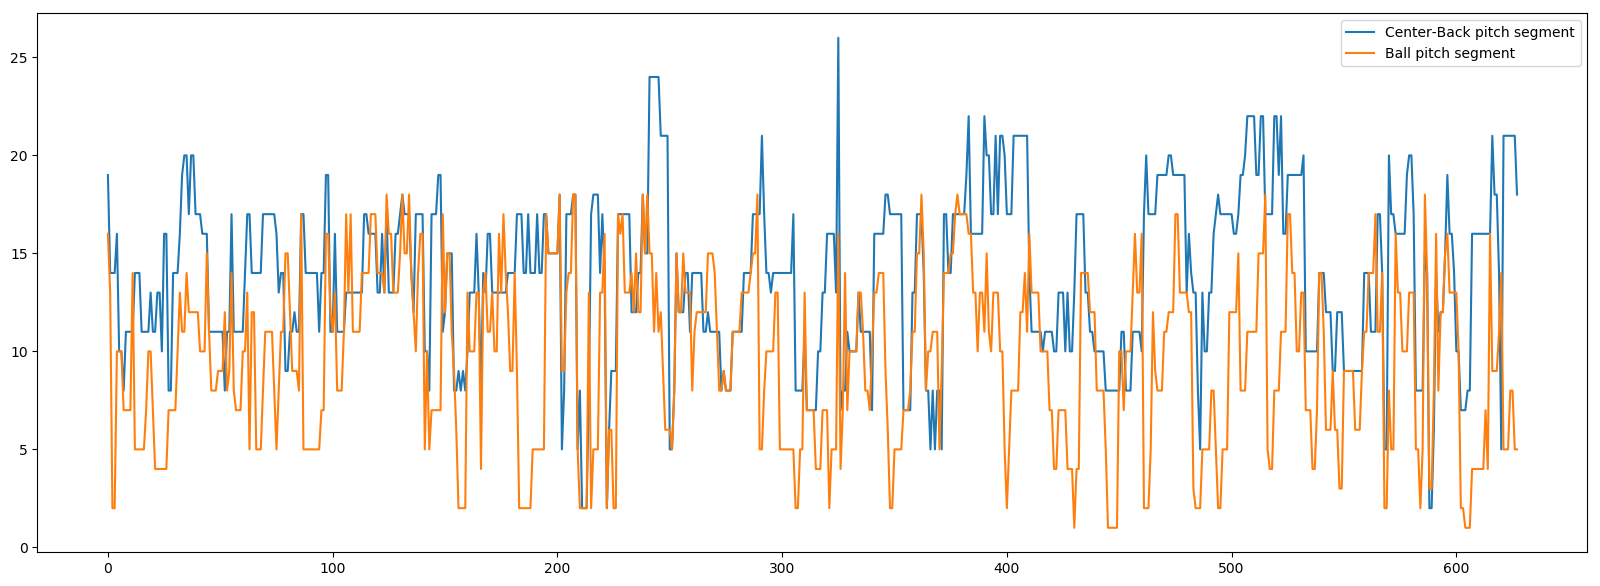

In [54]:
plt.figure(figsize=(20,7))
cb_df[['Center-Back pitch segment', 'Ball pitch segment']].plot(ax = plt.gca())
plt.show()

The slow Center-Back players' group are in front of the ball, and ball location is close to the goal region. This can be indicative of the times when *the goalkeeper starts the game*.

#### *ii. Center Back HIR group $(1.5\lt\vec{V}_{hir}\leq3)$ when ball actual position is $x_{ball}\leq50$* 

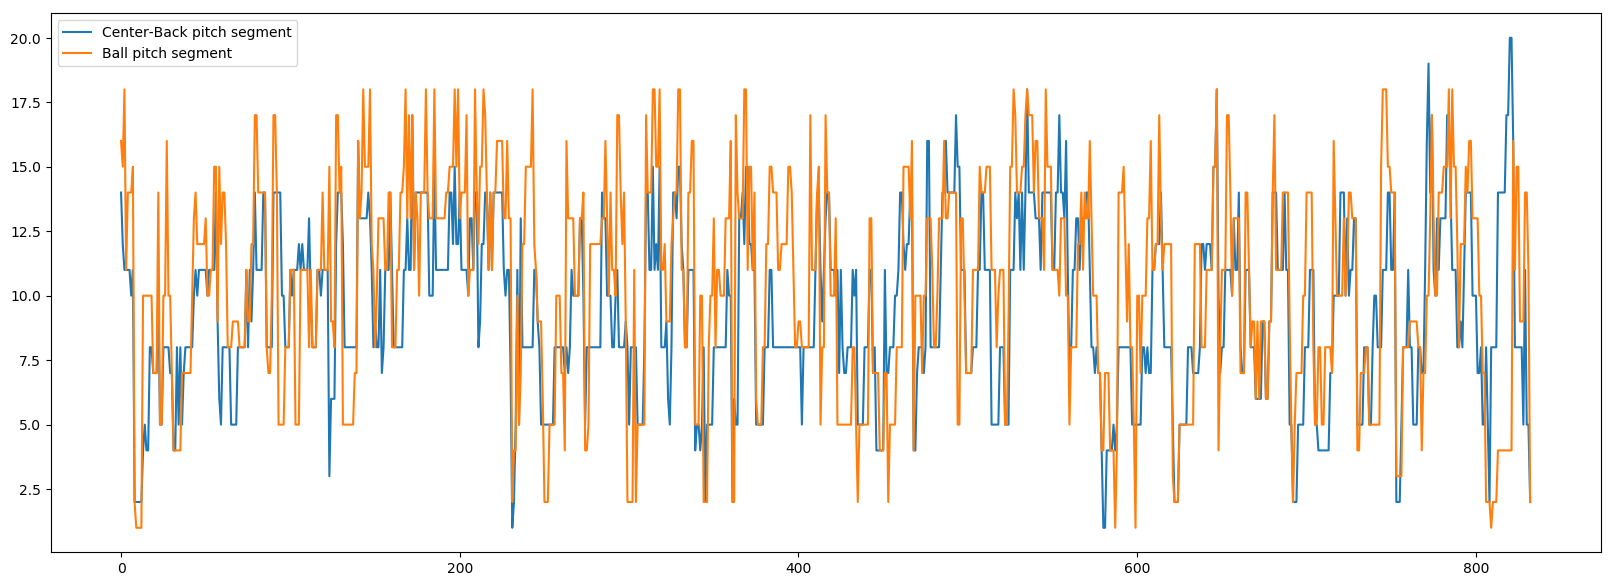

In [55]:
plt.figure(figsize=(20,7))
cb_df2[['Center-Back pitch segment', 'Ball pitch segment']].plot(ax = plt.gca())
plt.show()

Each speed groups in any players group shows different characteristic in terms of their distance to the ball location. Distance of __SLOW__ players group $(\vec{V}\leq1.5)$ to ball location is way far more than the distance between __HIR__ $(1.5\gt\vec{V}_{hir}\leq3)$ group and ball location. This can be understand in a way that, players those behind the ball generally moves. This can be very deterministic feature for our model. 

### Center Middlefielders

#### *i. Slow middlefielders $(\vec{V}_{slow}\leq1.5)$*

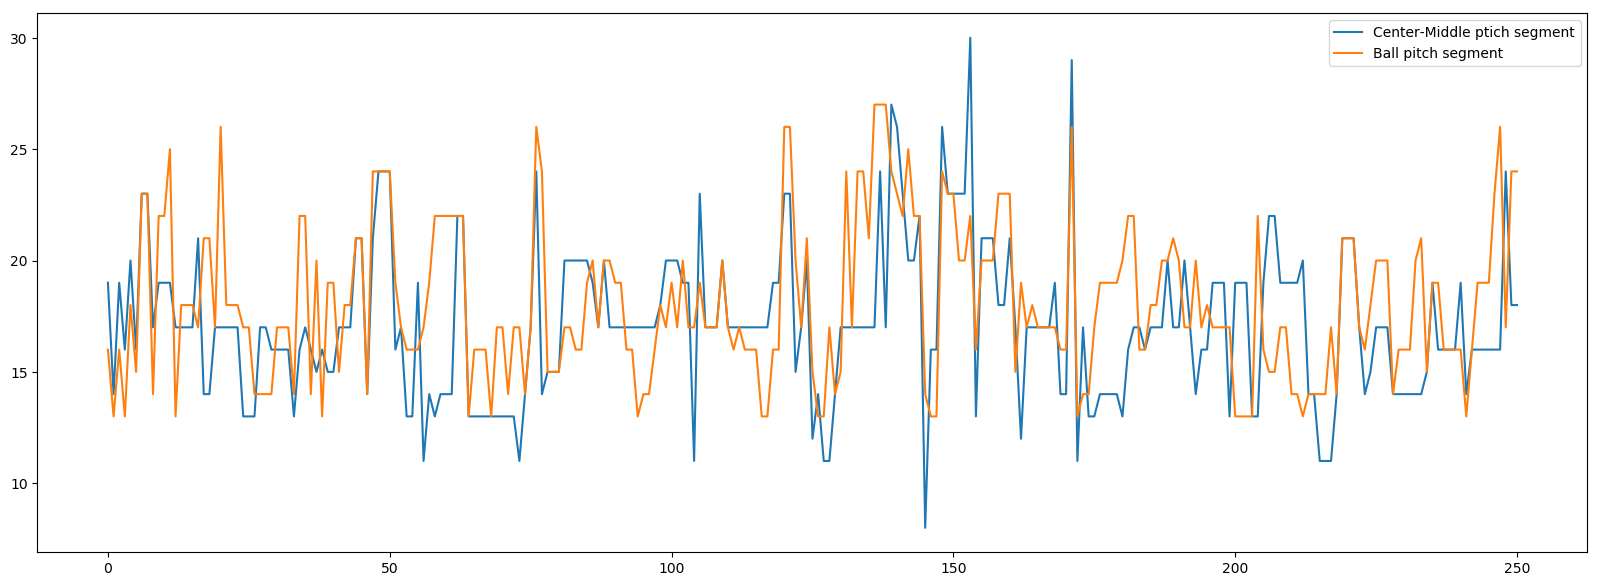

In [56]:
plt.figure(figsize=(20,7))
df[['Center-Middle ptich segment', 'Ball pitch segment']].plot(ax = plt.gca())
plt.show()

When the slow Center-Middle players' groups spread from 40m to 80m in the horizontal axis, they location tended to be behind of the ball and the ball location is more close to the opposite team's goal region. This may happen when team attacking. 

#### *ii. HIR group $(1.5\lt\vec{V}_{hir}\leq3)$*

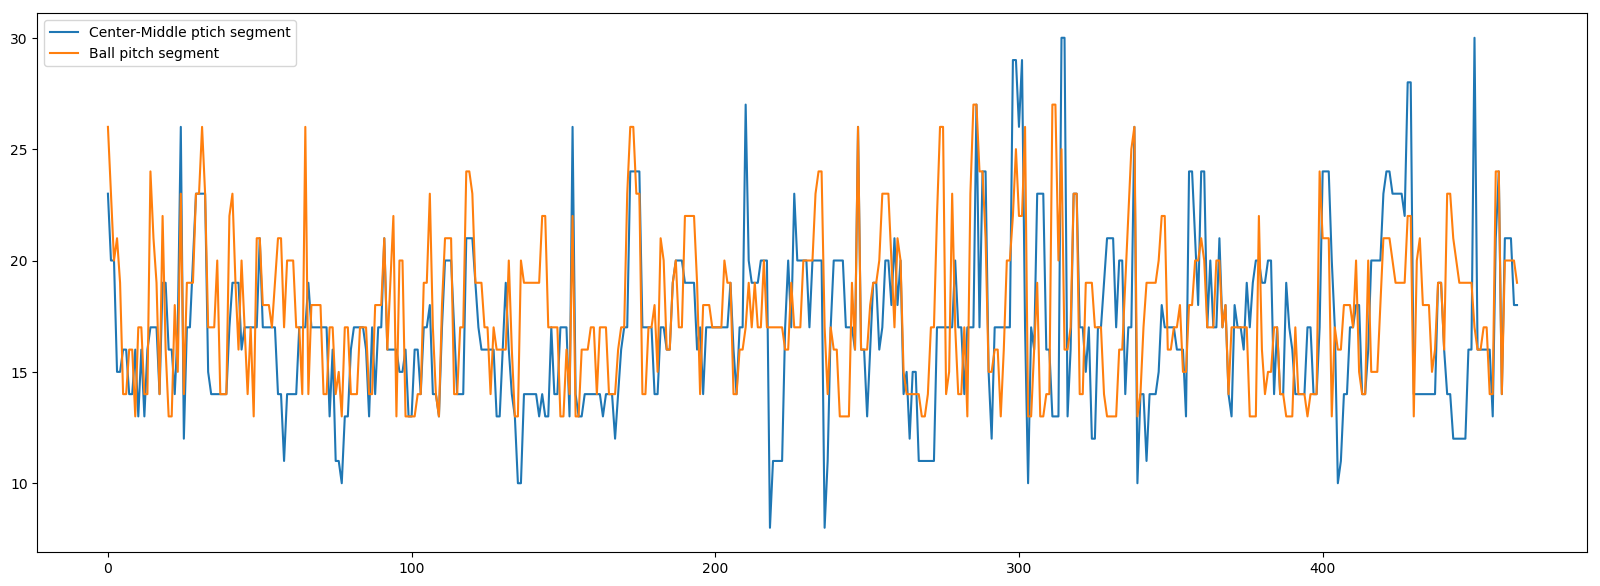

In [58]:
plt.figure(figsize=(20,7))
df1[['Center-Middle ptich segment', 'Ball pitch segment']].plot(ax = plt.gca())
plt.show()

The same situation with slow group's players also applies to the HIR groups player. But as they're moving faster their location, their location get close to the ball location, this means that they're active in the game and close to the ball at the moment. 

#### *iii. max-Sprint $max(\vec{V}_{sprint}\gt3)$*

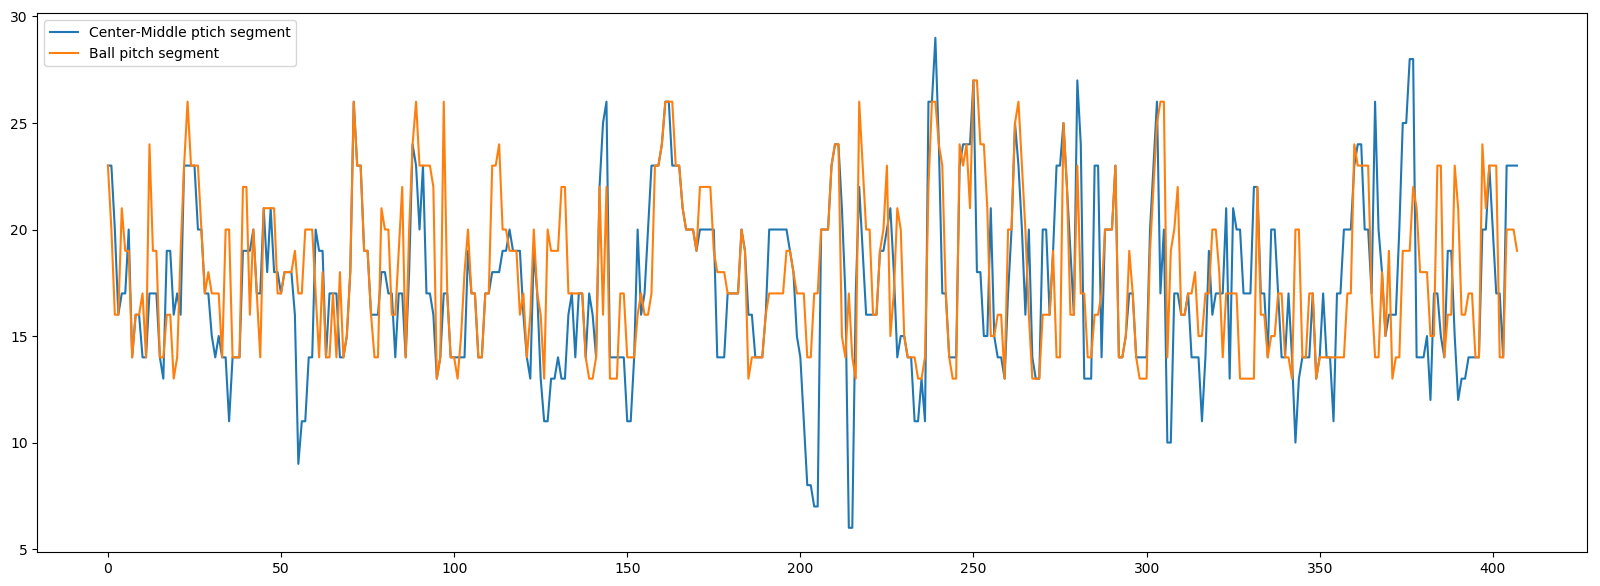

In [60]:
plt.figure(figsize=(20,7))
df2[['Center-Middle ptich segment', 'Ball pitch segment']].plot(ax = plt.gca())
plt.show()

Apart from the slow and HIR players groups, max-Sprint player location is close to the ball location in most of the times, this may imply that the player is actively participating in a game and very close to the ball location or he/she is controlling the ball at the moment.

### Direction Anlysis

#### *i. Referee  movement*

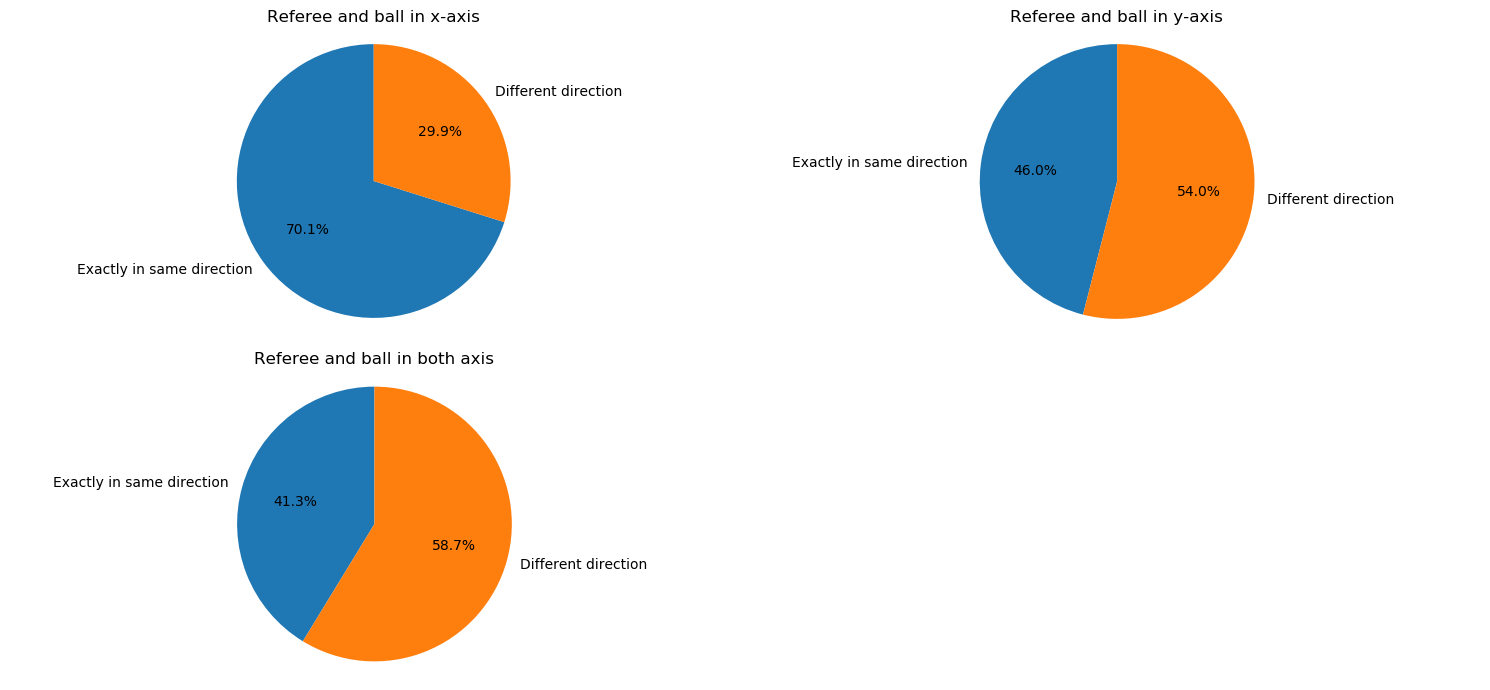

In [64]:
referee_direct = [features_df['refDirectX'], features_df['refDirectY']]
ball_cord = [features_df['xpos'], features_df['ypos']]
pitch_index = features_df['pitch_index']

referee_direct_l = []
ball_direct_l = []

for frame in range(1, len(features_df)):
    if ball_cord[0][frame]!=0 and pitch_index[frame]!=0:
        deltaX = ball_cord[0][frame]-ball_cord[0][frame-1]
        deltaY = ball_cord[1][frame]-ball_cord[1][frame-1]
        ball_direct_l.append([define_direction(deltaX),define_direction(deltaY)])
        referee_direct_l.append([referee_direct[0][frame], referee_direct[1][frame]])
        
ball_direct_l = np.array(ball_direct_l)
referee_direct_l = np.array(referee_direct_l)

data = {
'd_rx': referee_direct_l[:,0],
'd_ry': referee_direct_l[:,1],
'd_bx': ball_direct_l[:,0],
'd_by': ball_direct_l[:,1]
} 

same = 0
diff = 0
same_x = 0
diff_x = 0
same_y = 0
diff_y = 0

for i in range(len(data['d_rx'])):
    if data['d_rx'][i] == data['d_bx'][i]:
        same_x +=1
        
        if data['d_ry'][i] == data['d_by'][i]:
            same +=1
        else:
            diff +=1
    else:
        diff_x +=1
        
    if data['d_ry'][i] == data['d_by'][i]:
        same_y +=1
    else:
        diff_y +=1

labels = 'Exactly in same direction', 'Different direction' 
sizes = [same_x,diff_x]

plt.figure(figsize=(15, 7))
plt.subplot(2, 2, 1)
plt.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90)
plt.axis('equal')
plt.title('Referee and ball in x-axis')

sizes = [same_y,diff_y]
plt.subplot(2, 2, 2)
plt.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90)
plt.axis('equal')
plt.title('Referee and ball in y-axis')

sizes = [same,diff]
plt.subplot(2, 2, 3)
plt.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90)
plt.axis('equal')
plt.title('Referee and ball in both axis')

plt.tight_layout()

Average **directions** of movement in player groups and team do not not match with ball direction and it's significantly low, about 1-2%. In contrast, referee movement **direction** have same trend with ball direction in the most of times *(70% with x-axis, 46% with y-axis, and 41% in both directions)*.

### Max and Min coordinates $(x,y)$

Viewing histograms of maximum and minimum $x$ and $y$ values can give us an idea about the general game play regions in the match.

In [12]:
def get_data(x1, x2, x_pos, y_pos, raw_data):
    data = []
    for frame in range(len(features_df)):
        p_index = pith_index[frame]
        if x_pos[frame]>x1 and x_pos[frame]<x2 and p_index !=0:
            data.append(raw_data[frame])
    return np.array(data)

In [14]:
homeMaxX = get_data(0, 105, x_pos, y_pos, features_df['homeMaxX'])
homeMinX = get_data(0, 105, x_pos, y_pos, features_df['homeMinX'])
homeMaxY = get_data(0, 105, x_pos, y_pos, features_df['homeMaxY'])
homeMinY = get_data(0, 105, x_pos, y_pos, features_df['homeMinY'])

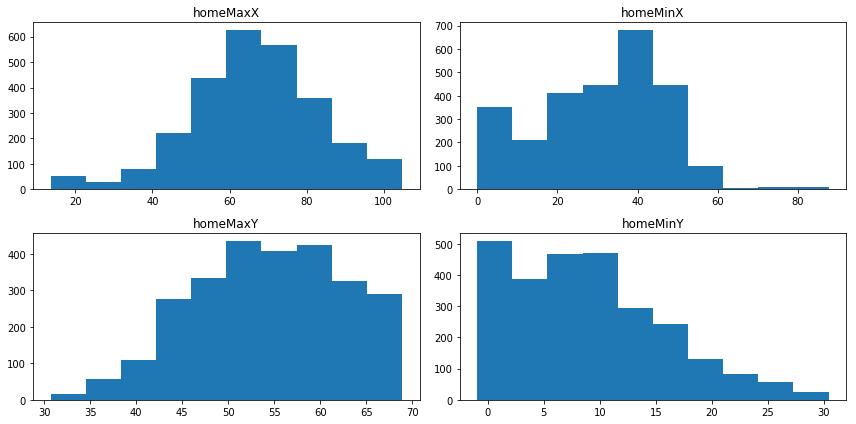

In [15]:
cols = {
        'homeMaxX' : homeMaxX,
        'homeMinX' : homeMinX,
        'homeMaxY' : homeMaxY,
        'homeMinY' : homeMinY
       }
i = 1
plt.figure(figsize=(12,6))
for col, (data) in cols.items():
    plt.subplot(2, 2, i)
    plt.title(col)
    plt.hist(data)
    i += 1
plt.tight_layout()

Additionally, the distributions of each player group **MaxX**, **MinY**, **MaxY**, **MinY** may indicate ball location more precisely.

### Groups denisty

#### i. Center Middle

In [26]:
centerslow = get_data(30, 60, x_pos, y_pos, features_df['homeCenterMiddleSlowDensity'])
centerhir = get_data(30, 60, x_pos, y_pos, features_df['homeCenterMiddleHirDensity'])

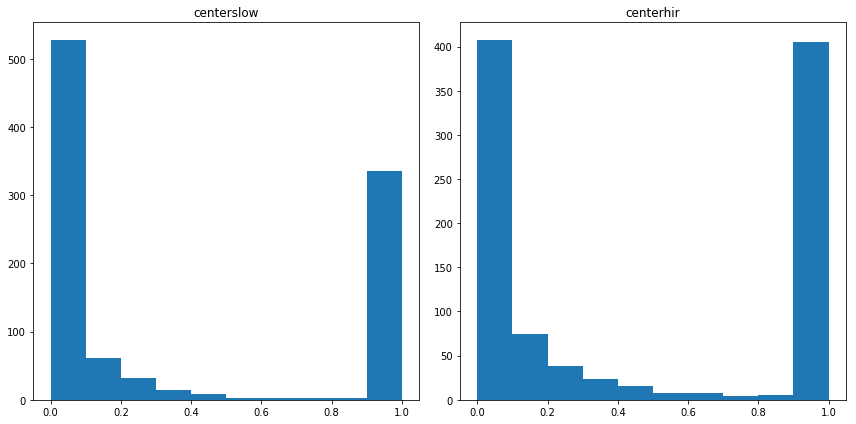

In [27]:
cols = {
        'centerslow' : centerslow,
        'centerhir' : centerhir,
       }
i = 1
plt.figure(figsize=(12,6))
for col, (data) in cols.items():
    plt.subplot(1, 2, i)
    plt.title(col)
    plt.hist(data)
    i += 1
plt.tight_layout()